# DECISION TREE FOR DIABETES DETECTION

Trains and visualizes unpruned and pruned decision trees.  Uses a small subset of the NHANES 2013/14 data set for diagnosing diabetes.  

NHANES website: https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/default.aspx

Author: Eric Eaton

Date: 20200127

In [0]:
# Uncomment and run this block if you would like to mount your drive
# from google.colab import drive
# drive.mount("/content/drive/")

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, make_scorer
from IPython.display import display
import matplotlib.pyplot as plt
import os

# Elect to display numerous columns instead of truncating them
pd.set_option('display.max_columns', 3000)


# Reading in the Data Set

After reading in the data set, it is a good habit to immediately investigate it, printing out summary statistics of the features, looking for missing values, etc.

In [7]:
# Read in the dataset.  Note that we have already removed the unique SEQN identifier
df = pd.read_csv('http://www.seas.upenn.edu/~cis519/datasets/NHANES-diabetes-examplesubset.csv')

df.head()

,AGE (RIDAGEYR),WAIST_CIRCUMFERENCE (BMXWAIST),HEIGHT (BMXHT),CHOLESTEROL (LBXTC),UPPER_LEG_LENGTH (BMXLEG),WEIGHT (BMXWT),BMI (BMXBMI),RACE (RIDRETH1),HIGH_BLOOD_PRESSURE (BPQ020),ALCOHOL_USE (ALQ120Q),EDUCATION (DMDEDUC2),GENDER (RIAGENDR),FAMILY_INCOME_RATIO (INDFMPIR),GLYCOHEMOGLOBIN (LBXGH),DIABETIC
0,43.0,72.7,163.3,148.0,36.4,54.3,20.4,Non-Hispanic White,2.0,1.0,5.0,2,0.84,5.2,0
1,39.0,112.0,165.5,142.0,45.5,96.2,35.1,Non-Hispanic Black,1.0,0.0,2.0,2,0.25,5.8,0
2,28.0,82.4,176.2,195.0,45.8,66.2,21.3,Mexican American,2.0,1.0,5.0,1,3.18,4.8,0
3,40.0,91.8,182.1,211.0,45.5,74.1,22.3,Other Hispanic,2.0,4.0,3.0,1,4.61,5.1,0
4,32.0,109.6,179.2,251.0,43.3,106.7,33.2,Non-Hispanic White,2.0,1.0,5.0,1,3.45,5.0,0


In [3]:
# Use Pandas' describe functionality to get summary statistics of the features
df.describe()

,AGE (RIDAGEYR),WAIST_CIRCUMFERENCE (BMXWAIST),HEIGHT (BMXHT),CHOLESTEROL (LBXTC),UPPER_LEG_LENGTH (BMXLEG),WEIGHT (BMXWT),BMI (BMXBMI),HIGH_BLOOD_PRESSURE (BPQ020),ALCOHOL_USE (ALQ120Q),EDUCATION (DMDEDUC2),GENDER (RIAGENDR),FAMILY_INCOME_RATIO (INDFMPIR),GLYCOHEMOGLOBIN (LBXGH),DIABETIC
count,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000,1547.00000,1547.000000,1547.000000,1547.000000,1547.000000,1547.000000
mean,50.929541,102.193859,168.211700,186.733678,38.952941,84.819651,29.892243,1.574661,3.38914,3.537169,1.466063,2.582754,6.063672,0.332902
std,16.893689,17.097129,10.076663,44.344516,3.868264,22.379503,7.157636,0.529912,15.82128,1.201178,0.499008,1.629210,1.399177,0.471404
min,20.000000,61.800000,140.900000,83.000000,26.700000,39.900000,15.200000,1.000000,0.00000,1.000000,1.000000,0.000000,3.900000,0.000000
25%,38.000000,90.100000,160.900000,156.000000,36.300000,68.900000,24.700000,1.000000,1.00000,3.000000,1.000000,1.110000,5.300000,0.000000
50%,51.000000,101.000000,167.800000,182.000000,38.900000,81.500000,28.500000,2.000000,2.00000,4.000000,1.000000,2.220000,5.600000,0.000000
75%,65.000000,112.300000,175.450000,213.000000,41.600000,96.900000,33.500000,2.000000,3.00000,5.000000,2.000000,4.190000,6.300000,1.000000
max,80.000000,160.700000,202.600000,813.000000,51.200000,184.000000,64.700000,9.000000,365.00000,9.000000,2.000000,5.000000,14.700000,1.000000


In [8]:
# Examine the dataset for missing features
print('Percentage of instances with missing features:')
print(df.isnull().sum(axis=0)/df.shape[0])
print()

# Examine the class information
print('Class information:')
print(df['DIABETIC'].value_counts())

Percentage of instances with missing features:
AGE (RIDAGEYR)                    0.0
WAIST_CIRCUMFERENCE (BMXWAIST)    0.0
HEIGHT (BMXHT)                    0.0
CHOLESTEROL (LBXTC)               0.0
UPPER_LEG_LENGTH (BMXLEG)         0.0
WEIGHT (BMXWT)                    0.0
BMI (BMXBMI)                      0.0
RACE (RIDRETH1)                   0.0
HIGH_BLOOD_PRESSURE (BPQ020)      0.0
ALCOHOL_USE (ALQ120Q)             0.0
EDUCATION (DMDEDUC2)              0.0
GENDER (RIAGENDR)                 0.0
FAMILY_INCOME_RATIO (INDFMPIR)    0.0
GLYCOHEMOGLOBIN (LBXGH)           0.0
DIABETIC                          0.0
dtype: float64

Class information:
0    1032
1     515
Name: DIABETIC, dtype: int64


# Preprocess the Dataset

Based on our analysis above, we next preprocess the dataset.  We first split it into X and y matrices, and then preprocess the features.  Finally, we need to divide it into training and held-out testing portions.

We have a whole set of potential preprocessing steps that we can perform, including:

*   Selecting the features to use in our model (deleting others)
*   Eliminating missing feature values
*   Imputing (filling in) missing values
    * There are many ways of imputing missing values.  For example, numeric features might be imputed with the mean value of that feature; categorical features might be imputed with the mode of that feature. However, there are implications of these choices, as we will cover late in the course.
*   Binarizing features
*   One-hot-encoding categorical features
*   etc.

We get to pick and choose among these options, depending on our dataset.  Each of our choices has implications on performance.  This is why, in machine learning, we build models, then examine their performance, and then go back to refine our process.  It is an iterative procedure to train an ML algorithm. Experiment, and then revise your choices!


In [9]:
# Split into X,y matrices
X = df.drop(['DIABETIC'], axis=1)
y = df['DIABETIC']

# One-hot encode categorical variables
# race/ethnicity is the only one we really need to encode; the others are essentially binary
X_onehots = pd.get_dummies(X['RACE (RIDRETH1)'], prefix=['RACE (RIDRETH1)_'])
X.drop('RACE (RIDRETH1)', axis = 1, inplace = True)
X = pd.concat([X, X_onehots], axis=1)


from sklearn.model_selection import train_test_split

# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


# Unpruned Decision Tree

We will first train and analyze an unpruned decision tree on the data.

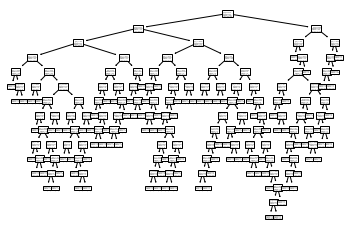

In [19]:
# Train a decision tree on the data
from sklearn import tree

# Train the decision tree
clf = tree.DecisionTreeClassifier(criterion='entropy')
clf = clf.fit(X_train, y_train)

# Plot the tree
tree.plot_tree(clf)

print()


### Measuring Performance and Detecting Overfitting

We will measure performance of the tree using accuracy across three aspects:
*   Training Error
*   An estimate of the test error, computed via cross-validation over the training data
*   The actual test error, as measured on held-out test data 

As we see, the training error is 0%, but both our estimates of the test error and our actual test error are much higher, indicating that we are overfitting.

In [15]:
# Measure the training error
y_pred = clf.predict(X_train)
print("Train error (Unpruned): " + str(((y_train != y_pred).sum()) / X_train.shape[0]) + "   N = " + str(X_train.shape[0]))

# Use cross-validation on the training data to get an estimate of the performance on unseen (test) data
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn import metrics
# Set number of trials and number of folds
NUM_TRIALS = 10
NUM_FOLDS = 10
# Array to store scores
scores = np.zeros(NUM_TRIALS * NUM_FOLDS) 
# Loop for each trial
for i in range(NUM_TRIALS):
  scores[i*NUM_FOLDS : (i+1)*NUM_FOLDS] = cross_val_score(tree.DecisionTreeClassifier(criterion='entropy'), 
                                                          X_train, 
                                                          y_train, 
                                                          cv=StratifiedKFold(NUM_FOLDS),  #StratifiedKFold ensures balanced class frequencies across folds
                                                          scoring='accuracy')
print("CV estimate of test error (Unpruned): %0.2f (+/- %0.2f)" % (1-scores.mean(), scores.std() * 2))


# Measure test error
y_pred = clf.predict(X_test)
print("Test error (Unpruned): " + str(((y_test != y_pred).sum()) / X_test.shape[0]) + "   N = " + str(X_test.shape[0]))

Train error (Unpruned): 0.0   N = 1082
CV estimate of test error (Unpruned): 0.16 (+/- 0.09)
Test error (Unpruned): 0.17204301075268819   N = 465


### Visualization

Next, we will visualize the unpruned tree using graphviz and dtreeviz.

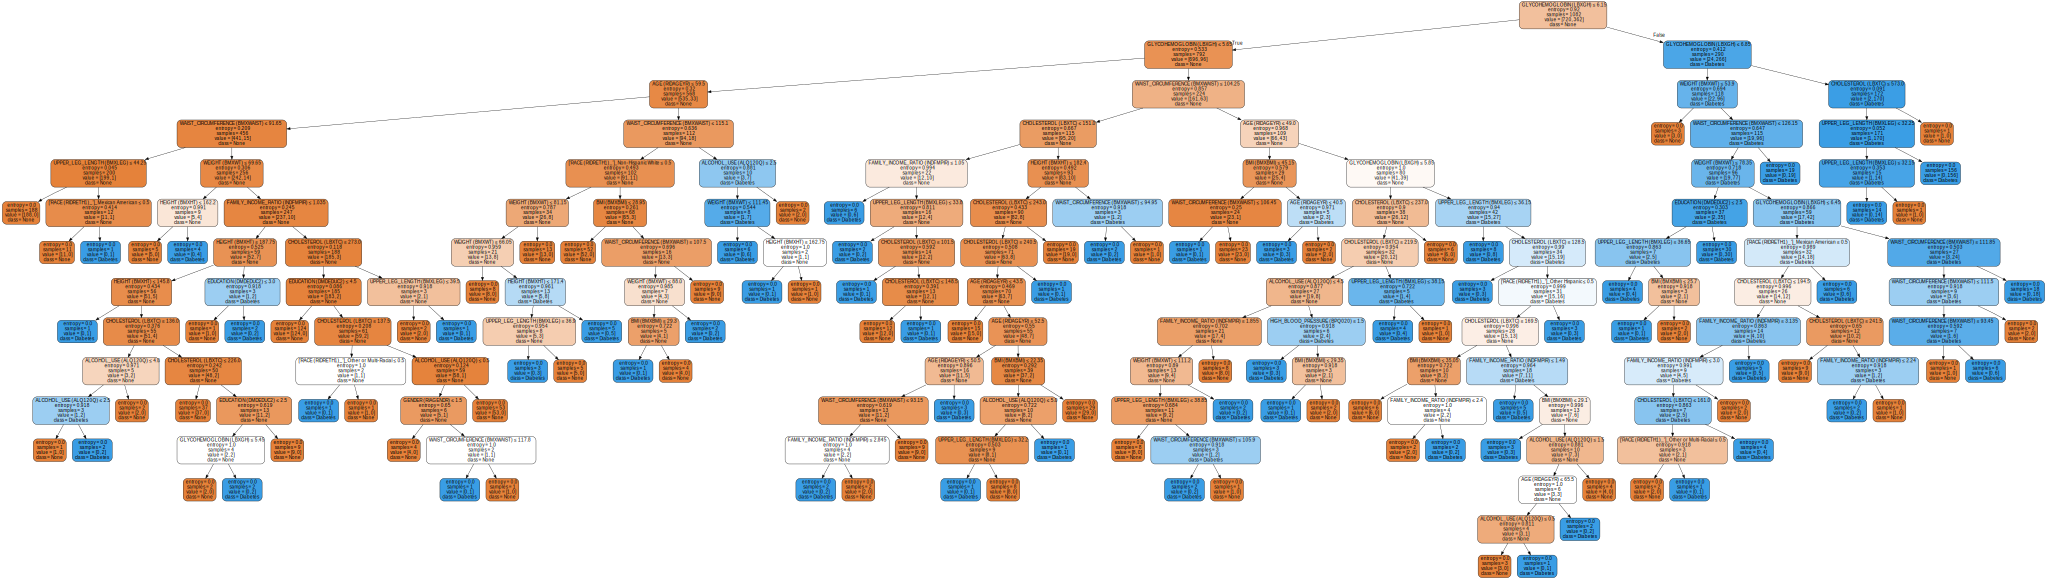

In [18]:
# visualize the decision tree
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("Unpruned Tree") 
dot_data = tree.export_graphviz(clf, out_file=None, 
                     feature_names=X.columns,  
                     class_names=['None', 'Diabetes'],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data) 
graph                                                 # display the graph


In [17]:
# visualize using dtreeviz library https://github.com/parrt/dtreeviz

# install dtreeviz
import sys
if 'google.colab' in sys.modules:
  !pip install -q dtreeviz

from dtreeviz.trees import *

# visualize tree
viz = dtreeviz(clf, 
               X_train,
               y_train,
               target_name='Diabetes',
               feature_names=X.columns,  
               class_names=['None', 'Diabetes'],  
               histtype= 'barstacked')               
viz

ModuleNotFoundError: No module named 'dtreeviz'

# Pruned Decision Tree

As we see, the unpruned tree fits the training data well, but fails to generalize well to unseen data.  Next we will train a pruned version of the tree.

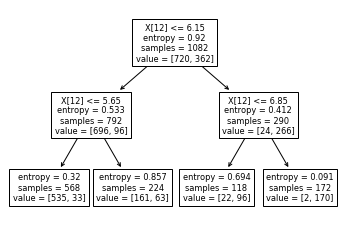

In [108]:
# Train the pruned tree
clf_pruned = tree.DecisionTreeClassifier(criterion='entropy', ccp_alpha=0.02)
clf_pruned = clf_pruned.fit(X_train, y_train)

# Plot the pruned tree
tree.plot_tree(clf_pruned)

print()


### Measuring Performance and Detecting a Correct Fit

We again measure performance of the tree using accuracy across three aspects:
*   Training Error
*   CV-estimate of the test error
*   Actual test error

As we see, the training error better matches the test error, indicating that we are not overfitting.





In [109]:
# Measure the training error
y_pred = clf_pruned.predict(X_train)
print("Train error (Pruned): " + str(((y_train != y_pred).sum()) / X_train.shape[0]) + "   N = " + str(X_train.shape[0]))

# Use cross-validation on the training data to get an estimate of the performance on unseen (test) data
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn import metrics
# Set number of trials and number of folds
NUM_TRIALS = 10
NUM_FOLDS = 10
# Array to store scores
scores = np.zeros(NUM_TRIALS * NUM_FOLDS) 
# Loop for each trial
for i in range(NUM_TRIALS):
  scores[i*NUM_FOLDS : (i+1)*NUM_FOLDS] = cross_val_score(tree.DecisionTreeClassifier(criterion='entropy', ccp_alpha=0.02), 
                                                          X_train, 
                                                          y_train, 
                                                          cv=StratifiedKFold(NUM_FOLDS),  #StratifiedKFold ensures balanced class frequencies across folds
                                                          scoring='accuracy')
print("CV estimate of test error (Pruned): %0.2f (+/- %0.2f)" % (1-scores.mean(), scores.std() * 2))

# Measure the actual test error
y_pred = clf_pruned.predict(X_test)
print("Actual test error (Pruned): " + str(((y_test != y_pred).sum()) / X_test.shape[0]) + "   N = " + str(X_test.shape[0]))

Train error (Pruned): 0.11090573012939002   N = 1082
CV estimate of test error (Pruned): 0.11 (+/- 0.06)
Actual test error (Pruned): 0.14408602150537633   N = 465


### Visualization

Next, we will visualize the pruned tree using graphviz and dtreeviz.

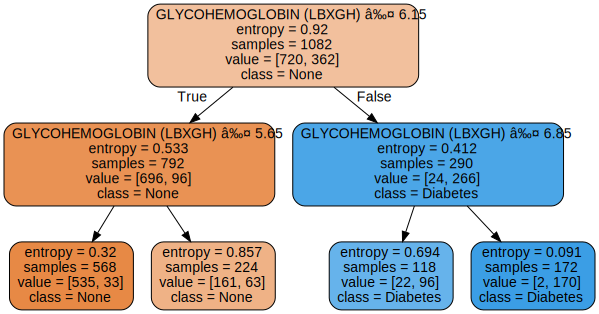

In [110]:
# visualize the decision tree
import graphviz 
dot_data = tree.export_graphviz(clf_pruned, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("Pruned Tree") 
dot_data = tree.export_graphviz(clf_pruned, out_file=None, 
                     feature_names=X.columns,  
                     class_names=['None', 'Diabetes'],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph                                                 # display the graph

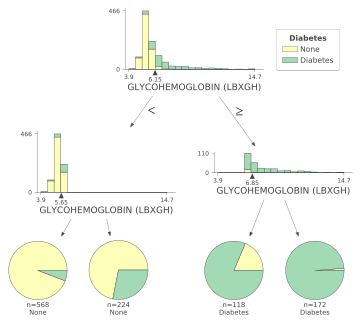

In [111]:
# visualize using dtreeviz library https://github.com/parrt/dtreeviz

# install dtreeviz
import sys
if 'google.colab' in sys.modules:
  !pip install -q dtreeviz

from dtreeviz.trees import *

# visualize tree
viz = dtreeviz(clf_pruned, 
               X_train,
               y_train,
               target_name='Diabetes',
               feature_names=X.columns,  
               class_names=['None', 'Diabetes'],  
               histtype= 'barstacked')                
viz

In [1]:
df

NameError: name 'df' is not defined

In [4]:
df

,AGE (RIDAGEYR),WAIST_CIRCUMFERENCE (BMXWAIST),HEIGHT (BMXHT),CHOLESTEROL (LBXTC),UPPER_LEG_LENGTH (BMXLEG),WEIGHT (BMXWT),BMI (BMXBMI),RACE (RIDRETH1),HIGH_BLOOD_PRESSURE (BPQ020),ALCOHOL_USE (ALQ120Q),EDUCATION (DMDEDUC2),GENDER (RIAGENDR),FAMILY_INCOME_RATIO (INDFMPIR),GLYCOHEMOGLOBIN (LBXGH),DIABETIC
0,43.0,72.7,163.3,148.0,36.4,54.3,20.4,Non-Hispanic White,2.0,1.0,5.0,2,0.84,5.2,0
1,39.0,112.0,165.5,142.0,45.5,96.2,35.1,Non-Hispanic Black,1.0,0.0,2.0,2,0.25,5.8,0
2,28.0,82.4,176.2,195.0,45.8,66.2,21.3,Mexican American,2.0,1.0,5.0,1,3.18,4.8,0
3,40.0,91.8,182.1,211.0,45.5,74.1,22.3,Other Hispanic,2.0,4.0,3.0,1,4.61,5.1,0
4,32.0,109.6,179.2,251.0,43.3,106.7,33.2,Non-Hispanic White,2.0,1.0,5.0,1,3.45,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542,62.0,90.4,191.9,239.0,42.3,85.1,23.1,Non-Hispanic Black,2.0,0.0,3.0,1,2.94,6.0,1
1543,50.0,120.5,164.1,155.0,32.1,92.3,34.3,Non-Hispanic Black,2.0,1.0,3.0,2,1.91,12.4,1
1544,41.0,153.0,186.0,180.0,45.5,166.3,48.1,Non-Hispanic White,2.0,1.0,2.0,1,5.00,6.6,1
1545,69.0,101.2,165.7,198.0,38.6,81.0,29.5,Mexican American,1.0,1.0,5.0,1,5.00,6.3,1
